<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

In [38]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
from collections import Counter
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
# from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
# from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
# import spacy

## Preprocessing :


In [2]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [3]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

In [1]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

In [ ]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [ ]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

In [7]:
df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')

In [8]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [9]:
 df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [10]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

In [11]:
df1 = pd.read_csv("nlp_features_train.csv", index_col=[0], usecols=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],encoding='latin-1')

df2 = pd.read_csv("df_fe_without_preprocessing_train.csv", usecols=['id','freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'], encoding = 'latin-1')

finaldf = df1.merge(df2, on = 'id')

In [12]:
finaldf.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

In [13]:
# finaldf = finaldf[0:180000]

## splitting the data for training and testing:


In [14]:
Y = finaldf['is_duplicate']
finaldf.drop(['is_duplicate'], axis=1, inplace=True)

In [15]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(finaldf, Y, stratify=Y, test_size=0.3)

# Assignment task 1:

## Applying TFIDF on Questions :

In [16]:
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [17]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
# questions = list(df['question1']) + list(df['question2'])
tfidf =TfidfVectorizer(lowercase=False, ngram_range=(1,4))
tfidf.fit(x_train['question1'].values.astype('U'))


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [19]:
x_train_tfidf_question_1 = tfidf.transform(x_train['question1'].values.astype('U'))
x_test_tfidf_question_1 = tfidf.transform(x_test['question1'].values.astype('U'))

In [20]:
print(x_train_tfidf_question_1.shape)
print(x_test_tfidf_question_1.shape)
print(x_train.shape)
print(x_test.shape)

(283003, 3108735)
(121287, 3108735)
(283003, 31)
(121287, 31)


In [21]:
tfidf =TfidfVectorizer(lowercase=False)
tfidf.fit(x_train['question2'].values.astype('U'))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [22]:
x_train_tfidf_question_2 = tfidf.transform(x_train['question2'].values.astype('U'))
x_test_tfidf_question_2 = tfidf.transform(x_test['question2'].values.astype('U'))

In [23]:
print(x_train_tfidf_question_1.shape)
print(x_train_tfidf_question_2.shape)
print(x_train.shape)
print(x_test_tfidf_question_1.shape)
print(x_test_tfidf_question_2.shape)
print(x_test.shape)

(283003, 3108735)
(283003, 53687)
(283003, 31)
(121287, 3108735)
(121287, 53687)
(121287, 31)


In [24]:
x_train = x_train.drop(['question1', 'question2', 'qid1','qid2','id'], axis = 1)
x_train.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
220919,0.666656,0.499994,0.571420,0.499994,0.615380,0.499997,0.0,0.0,3.0,14.5,...,9,83,65,15,12,6.0,27.0,0.222222,10,8
320654,0.000000,0.000000,0.999950,0.333328,0.499988,0.222220,1.0,1.0,5.0,6.5,...,4,41,23,9,4,3.0,12.0,0.250000,7,1
378170,0.749981,0.499992,0.999975,0.999975,0.874989,0.699993,0.0,1.0,2.0,9.0,...,1,35,52,8,10,7.0,18.0,0.388889,5,3
387783,0.249994,0.249994,0.666644,0.499988,0.428565,0.374995,0.0,0.0,1.0,7.5,...,1,42,43,7,8,3.0,15.0,0.200000,2,0
281732,0.799984,0.799984,0.999989,0.999989,0.812495,0.722218,1.0,1.0,2.0,17.0,...,3,73,81,15,16,13.0,29.0,0.448276,4,2


In [25]:
# x_train

In [26]:
x_test = x_test.drop(['question1', 'question2', 'qid1','qid2','id'], axis = 1)

In [27]:
from scipy.sparse import hstack
final_tfidf = hstack((x_train,x_train_tfidf_question_1,x_train_tfidf_question_2))
X_TRAIN = hstack((x_train, final_tfidf))

In [28]:
from scipy.sparse import hstack
final_tfidf = hstack((x_test,x_test_tfidf_question_1,x_test_tfidf_question_2))
X_TEST = hstack((x_test, final_tfidf))

In [29]:
X_TRAIN

<283003x3162474 sparse matrix of type '<class 'numpy.float64'>'
	with 26248436 stored elements in COOrdinate format>

In [30]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"       Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "                    Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517        Class 1:  0.36919749967314835
---------- Distribution of output variable in test data ----------
Class 0:  0.3691986775169639                     Class 1:  0.3691986775169639


In [37]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8838672525224123


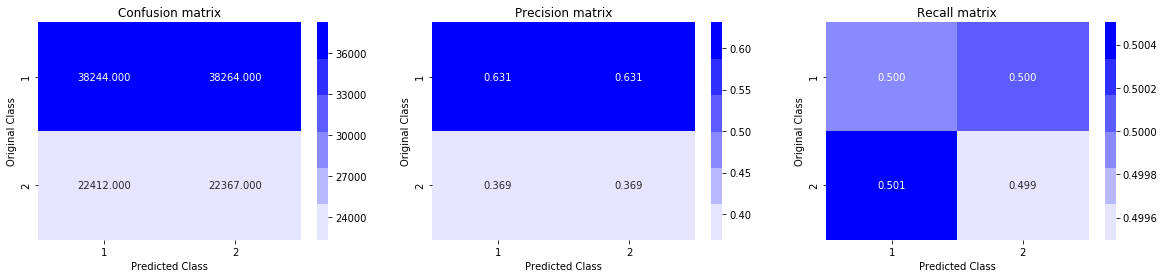

In [32]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.45188788631172644
For values of alpha =  0.0001 The log loss is: 0.45521462526831247
For values of alpha =  0.001 The log loss is: 0.45342227529624096
For values of alpha =  0.01 The log loss is: 0.4495985685016621
For values of alpha =  0.1 The log loss is: 0.4537131337027649
For values of alpha =  1 The log loss is: 0.47607127802426286
For values of alpha =  10 The log loss is: 0.5277129520866022


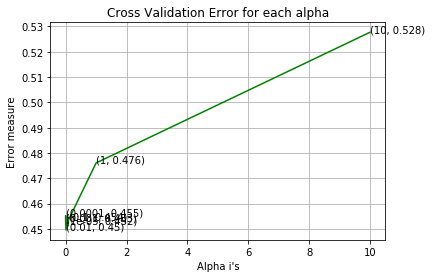

For values of best alpha =  0.01 The train log loss is: 0.4508941162958274
For values of best alpha =  0.01 The test log loss is: 0.4495985685016621
Total number of data points : 121287


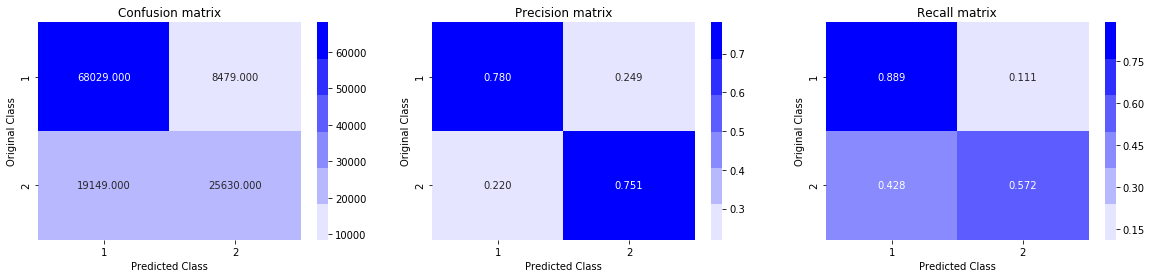

In [46]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_TRAIN, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_TRAIN, y_train)
    predict_y = sig_clf.predict_proba(X_TEST)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_TRAIN, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_TRAIN, y_train)

predict_y = sig_clf.predict_proba(X_TRAIN)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_TEST)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4626817184143489
For values of alpha =  0.0001 The log loss is: 0.47817314188676663
For values of alpha =  0.001 The log loss is: 0.5063470414554379
For values of alpha =  0.01 The log loss is: 0.52048385607797
For values of alpha =  0.1 The log loss is: 0.5041125214181629
For values of alpha =  1 The log loss is: 0.5687166210878194
For values of alpha =  10 The log loss is: 0.64371203737561


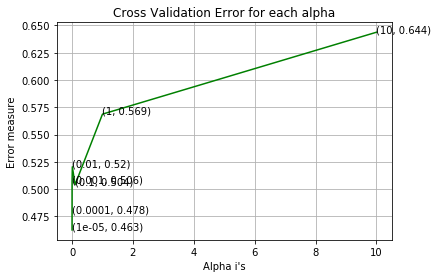

For values of best alpha =  1e-05 The train log loss is: 0.4645128492496849
For values of best alpha =  1e-05 The test log loss is: 0.4626817184143489
Total number of data points : 121287


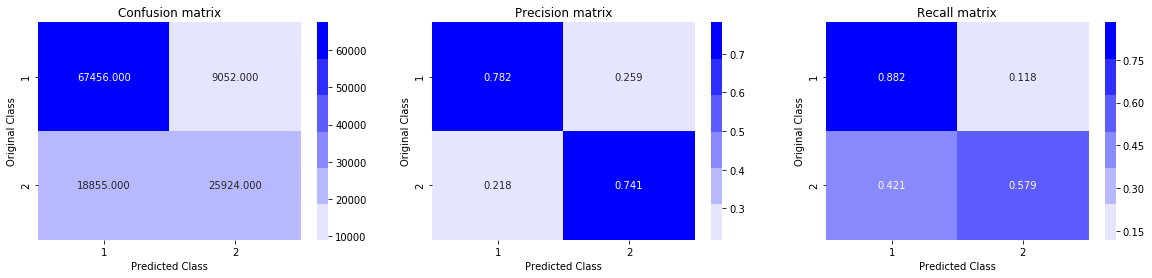

In [47]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

# from sklearn.linear_model import SGDClassifier
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_TRAIN, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_TRAIN, y_train)
    predict_y = sig_clf.predict_proba(X_TEST)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_TRAIN, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_TRAIN, y_train)

predict_y = sig_clf.predict_proba(X_TRAIN)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_TEST)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Hyperparamater tuning for XgBoost using RandomSearch

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [10]:
import xgboost as xg 
from xgboost.sklearn import XGBClassifier
from sqlalchemy import create_engine
import datetime as dt
#Creating db file from csv
# if not os.path.isfile('train.db'):
#     disk_engine = create_engine('sqlite:///train.db')
#     start = dt.datetime.now()
    
#     chunksize = 20000
#     j = 0
#     index_start = 1
#     for df in pd.read_csv('final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
#         df.index += index_start
#         j+=1
#         print('{} rows'.format(j*chunksize))
#         df.to_sql('data', disk_engine, if_exists='append')
#         index_start = df.index[-1] + 1



In [11]:
import pickle
with open('quora_variables', 'rb') as f:
    X_train, X_test = pickle.load(f)

In [12]:
Y_train = X_train['is_duplicate']
Y_test = X_test['is_duplicate']
X_train = X_train.drop(['is_duplicate'], axis=1)
X_test = X_test.drop(['is_duplicate'], axis=1)
predictors = X_train.columns

In [13]:
X_train = X_train.drop(['question1', 'question2', 'q1_feats_m', 'q2_feats_m'], axis = 1)
X_test = X_test.drop(['question1', 'question2', 'q1_feats_m', 'q2_feats_m'], axis = 1)

In [14]:
# #http://www.sqlitetutorial.net/sqlite-python/create-tables/
# import sqlite3
# def create_connection(db_file):
#     """ create a database connection to the SQLite database
#         specified by db_file
#     :param db_file: database file
#     :return: Connection object or None
#     """
#     try:
#         conn = sqlite3.connect(db_file)
#         return conn
#     except Error as e:
#         print(e)
 
#     return None


# def checkTableExists(dbcon):
#     cursr = dbcon.cursor()
#     str = "select name from sqlite_master where type='table'"
#     table_names = cursr.execute(str)
#     print("Tables in the databse:")
#     tables =table_names.fetchall() 
#     print(tables[0][0])
#     return(len(tables))

In [12]:
# read_db = 'train.db'
# conn_r = create_connection(read_db)
# checkTableExists(conn_r)
# conn_r.close()

In [13]:
# # try to sample data according to the computing power you have
# if os.path.isfile(read_db):
#     conn_r = create_connection(read_db)
#     if conn_r is not None:
# #         for selecting first 1M rows
#         data = pd.read_sql_query("""SELECT * FROM data LIMIT 90000;""", conn_r)
        
#         # for selecting random points
# #         data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 10000;", conn_r)
#         conn_r.commit()
#         conn_r.close()

In [14]:
# X_train

In [15]:
# X_test

In [4]:
Y_train = X_train['is_duplicate']
Y_test = X_test['is_duplicate']
# # remove the first row 
# # data.drop(data.index[0], inplace=True)
# # y_true = data['is_duplicate']
# # data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)
# X_train.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)
# X_test.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)

In [20]:
# data.shape

numpy.int64

In [11]:
# # after we read from sql table each entry was read it as a string
# # we convert all the features into numaric before we apply any model
# cols = list(data.columns)
# for i in cols:
#     data[i] = data[i].apply(pd.to_numeric)
#     print(i)

In [22]:
# # https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
# y_true = list(map(int, y_true.values))

In [18]:
# from sklearn.model_selection import train_test_split
# X_train,X_test, Y_train, Y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [17]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 797)
Number of data points in test data : (121287, 797)


In [18]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(Y_train)
train_len = len(Y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(Y_test)
test_len = len(Y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [35]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# XGBoost


In [31]:
predictors = X_train.columns
predictors = list(map(str, predictors.values))

In [7]:
import xgboost
from xgboost import XGBClassifier
from sklearn import metrics
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)

    return plot_importance(booster=booster, ax=ax, max_num_features=40)

def xgb_model(model,train_, test_):
    xgb_param = model.get_xgb_params()
    xgtrain = xgboost.DMatrix(train_, label = Y_train)
    cv_result = xgboost.cv(xgb_param, xgtrain,
                           num_boost_round=model.get_params()['n_estimators'],
                           metrics= 'auc',
                           early_stopping_rounds=50)
    model.set_params(n_estimators =cv_result.shape[0])      
    model.fit(train_, Y_train, eval_metric='auc')
    train_predict = model.predict(train_)
    train_predict_proba = model.predict_proba(train_)[:,-1]
    print("Train Accuracy : %.4g" % metrics.accuracy_score(Y_train, train_predict))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(Y_train, train_predict_proba))
    print('#'*50)
    test_predict = model.predict(test_)
    test_predict_proba = model.predict_proba(test_)[:,-1]
    print("Test Accuracy : %.4g" % metrics.accuracy_score(Y_test, test_predict))
    print("AUC Score (test): %f" % metrics.roc_auc_score(Y_test, test_predict_proba))
    model.get_booster().feature_names = predictors
    plot_features(model, (16,27))
    


In [5]:
# xgb1 = XGBClassifier(
#  learning_rate =0.1,
# #  n_estimators=1000,
#  max_depth=6,
# #  min_child_weight=1,
# #  gamma=0,
# #  subsample=0.8,
# #  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)
# xgb_model(xgb1, X_train, X_test)

## tuning max_depth and min_child weight

In [ ]:
# from sklearn.model_selection import GridSearchCV
# param_test1 = {
#  'max_depth':range(6,14,2),
#  'min_child_weight':range(1,6,2)
# }
# gsearch1 = GridSearchCV(
#     estimator = XGBClassifier(learning_rate =0.1, 
#                               n_estimators=140, 
#                               max_depth=5,
#                               min_child_weight=1, 
#                               gamma=0, 
#                               subsample=0.8, 
#                               colsample_bytree=0.8,
#                               objective= 'binary:logistic', 
#                               nthread=4, 
#                               scale_pos_weight=1, 
#                               seed=27), 
#     param_grid = param_test1, 
#     scoring='roc_auc',
#     n_jobs=3,
#     iid=False,
#     cv=5)
# gsearch1.fit(X_train,Y_train)
# # gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_gb1, (15,25))

In [26]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'max_depth':range(6,12,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(
    estimator = XGBClassifier(learning_rate =0.1, 
                              n_estimators=140,  
                              gamma=0, 
                              subsample=0.8, 
                              colsample_bytree=0.8,
                              objective= 'binary:logistic', 
                              nthread=4, 
                              scale_pos_weight=1, 
                              seed=27), 
    param_grid = param_test1, 
    scoring='roc_auc',
    n_jobs=3,
    iid=False,
    cv=5)
gsearch1.fit(X_train,Y_train)
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_gb1, (15,25))

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=140, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid=False, n_jobs=3,
       param_grid={'max_depth': range(6, 12, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [27]:
gsearch1.best_params_

{'max_depth': 10, 'min_child_weight': 5}

In [20]:
final_xgb = XGBClassifier(learning_rate =0.1,       
                          n_estimators=140,  
                          gamma=0, 
                          subsample=0.8, 
                          colsample_bytree=0.8,
                          objective= 'binary:logistic', 
                          nthread=4,
                          max_depth=10,
                          min_child_weight=5,
                          scale_pos_weight=1, 
                          seed=27)
# xgb_model(final_xgb, X_train, X_test)

In [21]:
xgb_param = final_xgb.get_xgb_params()
xgtrain = xgboost.DMatrix(X_train, label = Y_train)
cv_result = xgboost.cv(xgb_param, xgtrain,
                       num_boost_round=final_xgb.get_params()['n_estimators'],
                       metrics= 'auc',
                       early_stopping_rounds=50)
final_xgb.set_params(n_estimators =cv_result.shape[0])      

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=5, missing=None, n_estimators=140, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1)

In [22]:
final_xgb.fit(X_train, Y_train, eval_metric='auc')
X_trainpredict = final_xgb.predict(X_train)
X_trainpredict_proba = final_xgb.predict_proba(X_train)[:,-1]
print("Train Accuracy : %.4g" % metrics.accuracy_score(Y_train, X_trainpredict))
print("AUC Score (Train): %f" % metrics.roc_auc_score(Y_train, X_trainpredict_proba))
print('#'*50)
X_testpredict = final_xgb.predict(X_test)
X_testpredict_proba = final_xgb.predict_proba(X_test)[:,-1]
print("Test Accuracy : %.4g" % metrics.accuracy_score(Y_test, X_testpredict))
print("AUC Score (test): %f" % metrics.roc_auc_score(Y_test, X_testpredict_proba))

Train Accuracy : 0.9533
AUC Score (Train): 0.991679
##################################################
Test Accuracy : 0.8552
AUC Score (test): 0.936868


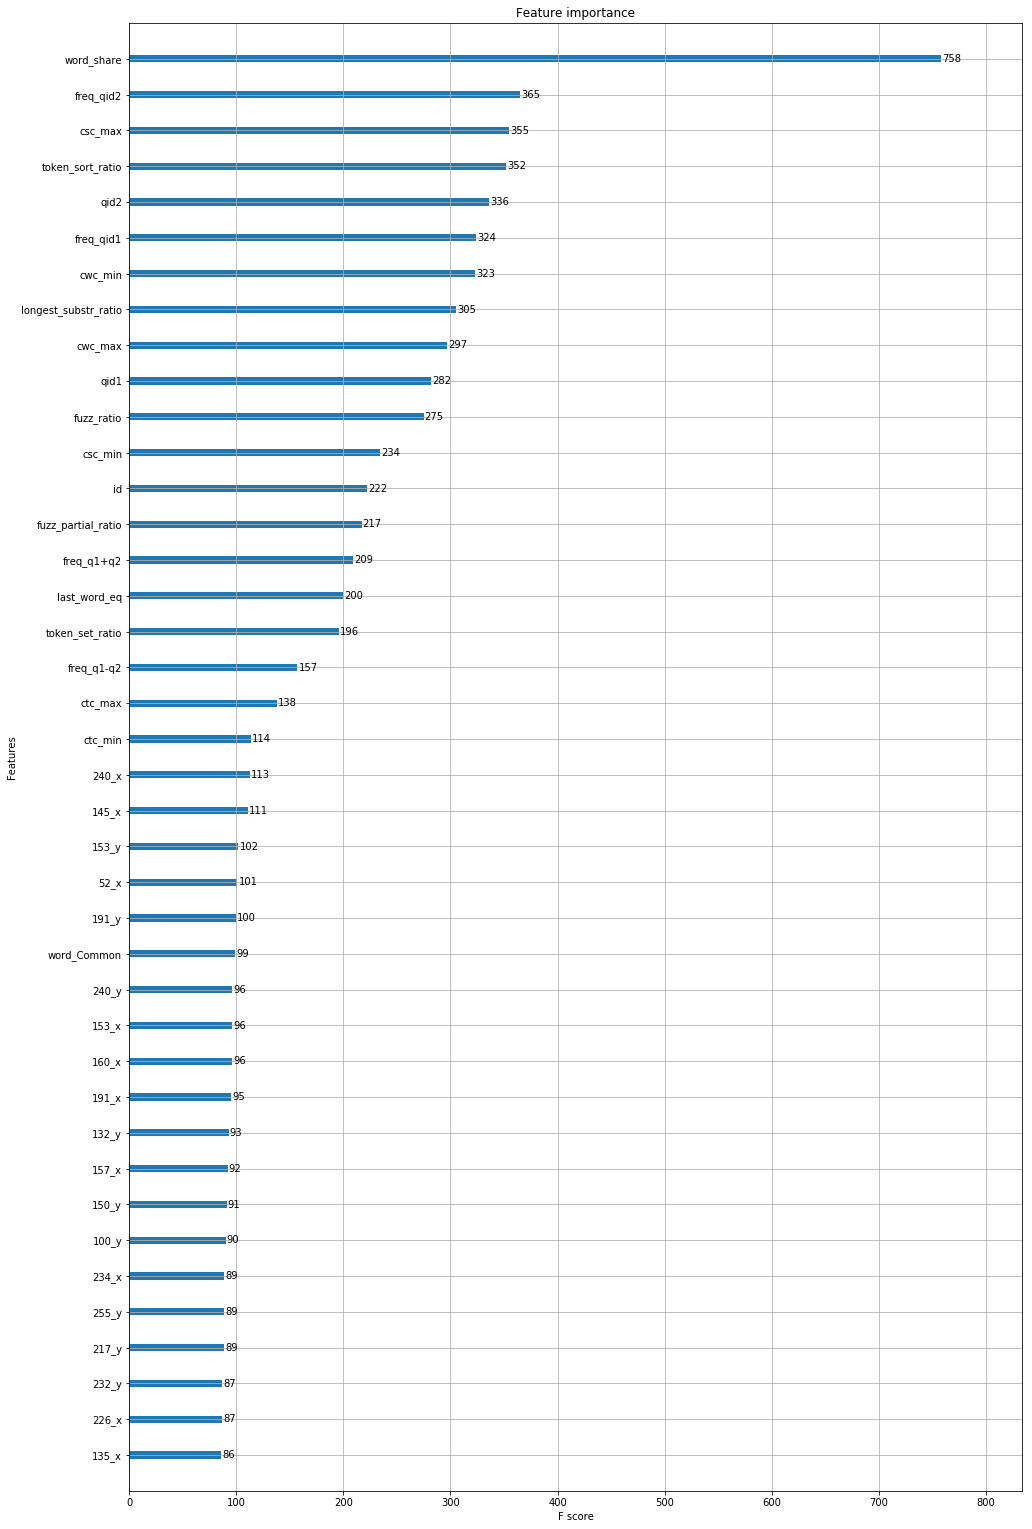

In [34]:
final_xgb.get_booster().feature_names = predictors
plot_features(final_xgb, (16,27))

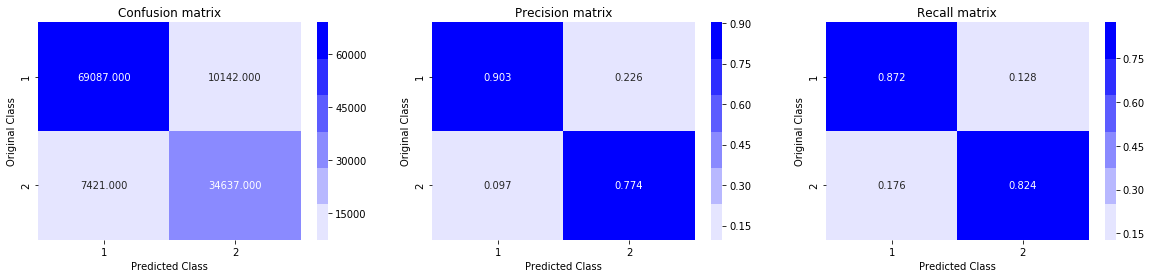

In [39]:
plot_confusion_matrix(X_testpredict, Y_test)